In [1]:
from mono.model.monodepth_model import get_configured_monodepth_model
from mono.utils.running import load_ckpt
try:
    from mmcv.utils import Config
    # from mmcv.utils import Config, DictAction
except:
    from mmengine import Config
    # from mmengine import Config, DictAction
import cv2
import matplotlib.pyplot as plt
import open3d as o3d
import numpy as np
import torch
from PIL import Image
from mono.utils.do_test import transform_test_data_scalecano, get_prediction

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
cfg_large = Config.fromfile('./mono/configs/HourglassDecoder/vit.raft5.large.py')
model_large = get_configured_monodepth_model(cfg_large, )
model_large, _,  _, _ = load_ckpt('./weight/metric_depth_vit_large_800k.pth', model_large, strict_match=False)
model_large.eval()
device = "cuda"
# device = "cpu"
model_large.to(device)


Triton is not available, some optimizations will not be enabled.
This is just a warning: No module named 'triton'
A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'


DepthModel(
  (depth_model): DensePredModel(
    (encoder): DinoVisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
        (norm): Identity()
      )
      (blocks): ModuleList(
        (0): BlockChunk(
          (0-23): 24 x Block(
            (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
            (attn): MemEffAttention(
              (qkv): Linear(in_features=1024, out_features=3072, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=1024, out_features=1024, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
            )
            (ls1): LayerScale()
            (drop_path1): Identity()
            (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=1024, out_features=4096, bias=True)
              (act): GELU(approximate='none')
          

In [3]:
def predict_depth_normal(img, fx=1000.0, fy=1000.0, state_cache={}):
    # if model_selection == "vit-small":
    #     model = model_small
    #     cfg = cfg_small
    # elif model_selection == "vit-large":
    #     model = model_large
    #     cfg = cfg_large

    # else:
    #     return None, None, None, None, state_cache, "Not implemented model."
    
    if img is None:
        return None, None, None, None, state_cache, "Please upload an image and wait for the upload to complete."

    model = model_large
    cfg = cfg_large
    cv_image = np.array(img) 
    img = cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB)
    intrinsic = [fx, fy, img.shape[1]/2, img.shape[0]/2]
    rgb_input, cam_models_stacks, pad, label_scale_factor = transform_test_data_scalecano(img, intrinsic, cfg.data_basic)
    
    with torch.no_grad():
        pred_depth, pred_depth_scale, scale, output, confidence = get_prediction(
                    model = model,
                    input = rgb_input,
                    cam_model = cam_models_stacks,
                    pad_info = pad,
                    scale_info = label_scale_factor,
                    gt_depth = None,
                    normalize_scale = cfg.data_basic.depth_range[1],
                    ori_shape=[img.shape[0], img.shape[1]],
                )
    pred_depth = pred_depth.squeeze().cpu().numpy()
    pred_depth[pred_depth<0] = 0
    # pred_color = gray_to_colormap(pred_depth)

    pred_normal = output['normal_out_list'][0][:, :3, :, :] 
    H, W = pred_normal.shape[2:]
    pred_normal = pred_normal[:, :, pad[0]:H-pad[1], pad[2]:W-pad[3]]
    pred_normal = torch.nn.functional.interpolate(pred_normal, [img.shape[0], img.shape[1]], mode='bilinear').squeeze()
    pred_normal = pred_normal.permute(1,2,0)
    pred_normal = pred_normal.cpu().numpy()

    return  pred_depth, pred_depth_scale, scale, pred_normal

In [58]:
def depth_to_point_cloud(depth_image, fx, fy, cx, cy):
    height, width = depth_image.shape
    # width,height = depth_image.shape
    u, v = np.meshgrid(np.arange(width), np.arange(height))
    
    Z = depth_image
    X = (u - cx) * Z / fx
    Y = (v - cy) * Z / fy
    
    point_cloud = np.stack((X, Y, Z), axis=-1)
    return point_cloud

In [100]:
img = Image.open("IMG20240610231531.jpg")
# img = Image.open("IMG20240610231100.jpg")
depth_map,pred_depth_scale,scale,pred_normal=predict_depth_normal(img, fx=1000.0, fy=1000.0, state_cache={})

(4096, 3072)


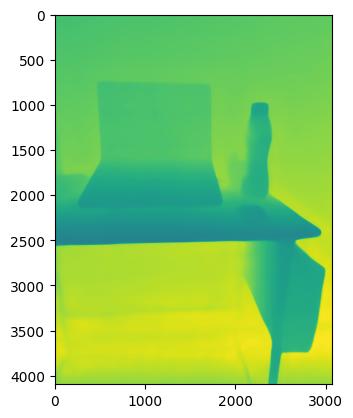

In [101]:

print(depth_map.shape)
plt.imshow(depth_map)

In [102]:
fx=1000.0
fy=1000.0
img=np.array(img)
intrinsic = [fx, fy, img.shape[1]/2, img.shape[0]/2]
# intrinsic = [fx, fy, img.size[0]/2, img.size[1]/2]
if depth_map.shape[0] > 1080:
        scale = 1080 / depth_map.shape[0]
        depth_map = cv2.resize(depth_map, (0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
        img = cv2.resize(img, (0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
        intrinsic = [intrinsic[0]*scale, intrinsic[1]*scale, intrinsic[2]*scale, intrinsic[3]*scale]

In [103]:
def get_pcd_base(H, W, u0, v0, fx, fy):
    x_row = np.arange(0, W)
    x = np.tile(x_row, (H, 1))
    x = x.astype(np.float32)
    u_m_u0 = x - u0

    y_col = np.arange(0, H)  # y_col = np.arange(0, height)
    y = np.tile(y_col, (W, 1)).T
    y = y.astype(np.float32)
    v_m_v0 = y - v0

    x = u_m_u0 / fx
    y = v_m_v0 / fy
    z = np.ones_like(x)
    pw = np.stack([x, y, z], axis=2)  # [h, w, c]
    return pw

In [104]:
if type(depth_map) == torch.__name__:
        depth_map = depth_map.cpu().numpy().squeeze()
depth_map = cv2.medianBlur(depth_map, 5)
H, W = depth_map.shape
pcd_base = get_pcd_base(H, W, intrinsic[2], intrinsic[3], intrinsic[0], intrinsic[1])
pcd = depth_map[:, :, None] * pcd_base
pcd.shape


(1080, 810, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7811386..0.8911595].


(1080, 810, 3)


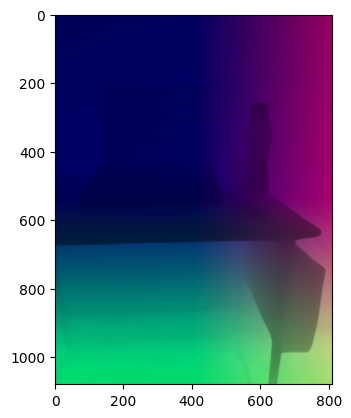

In [105]:
print(pcd.shape)
plt.imshow(pcd)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9999766..0.97880924].


(4096, 3072, 3)


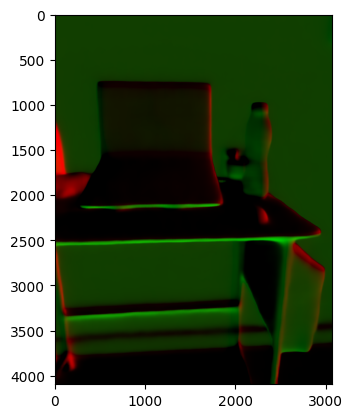

In [106]:
print(pred_normal.shape)
plt.imshow(pred_normal)

(1080, 810, 3)


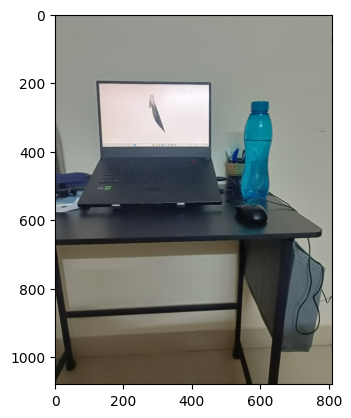

In [107]:
print(img.shape)
plt.imshow(img)

In [108]:
pcd_filtered = pcd.reshape(-1, 3)
img_filtered = img.reshape(-1, 3)
pred_normal2=pred_normal.reshape(-1,3)

In [109]:
img_filtered[0]

array([145, 146, 138], dtype=uint8)

In [110]:
pcd2 = o3d.geometry.PointCloud()
pcd2.points = o3d.utility.Vector3dVector(pcd_filtered)
print("points")
pcd2.colors = o3d.utility.Vector3dVector(np.array(img_filtered)/255.0)
print("color")
pcd2.normals = o3d.utility.Vector3dVector(pred_normal2)
print("normal")
pcd3 = pcd2.voxel_down_sample(voxel_size=0.002)

points
color
normal


In [114]:
# pcd2 = pcd.voxel_down_sample(voxel_size=0.002)
o3d.visualization.draw_geometries([pcd3])

In [112]:
o3d.io.write_point_cloud("total_pcd.pcd", pcd2)
o3d.io.write_point_cloud("voxel_down_pcd.pcd", pcd3)

True

In [113]:
pcd2.colors = o3d.utility.Vector3dVector(img_filtered)
o3d.visualization.draw_geometries([pcd2])